# Portfolio Project: EDA & Customer Segmentation - Online Retail Store

Performed by: [Sougat Dey](#https://www.linkedin.com/in/sougatdey/)

## About Me

<div style="text-align: justify"> I'm Sougat Dey, an aspiring Data Scientist with a solid background in Python and Statistics. This project signifies my second step into the realm of Machine Learning, where I'm delving into Exploratory Data Analysis (EDA) and Customer Segmentation using a dataset from an Online Retail Store. Through this endeavor, I aim to showcase not just my technical skills but also my ability to derive meaningful insights and actionable strategies from data. Join me as we unravel the intricacies of EDA and create targeted customer segments to enhance business strategies in the online retail domain. </div>

#### Connect on <a href = "https://www.linkedin.com/in/sougatdey/"> LinkedIn </a>.

## Introduction

<div style="text-align: justify"> This project focuses on Exploratory Data Analysis (EDA) and Customer Segmentation using data from an UK-based Online Retail Store. The dataset includes crucial information such as Invoice numbers, Stock codes, Product descriptions, Quantities sold, Invoice dates, Unit prices, Customer identifiers, and transaction countries. Metadata is mentioned below. </div>

### Exploratory Data Analysis (EDA)

Through EDA, significant insights have been uncovered, including sales trends, product popularity, customer purchasing patterns, and geographical transaction variations.

### Customer Segmentation

Advanced segmentation techniques categorize customers based on buying behaviors, preferences, and demographics, enabling targeted marketing and improved customer experiences.

### Project Goals

- Conduct comprehensive EDA for dataset understanding.
- Perform Customer Segmentation for targeted strategies.
- Derive actionable insights for business optimization in online retail.


## Metadata
The dataset contains the following columns:

- InvoiceNo: Invoice number of the transaction
- StockCode: Unique code of the product
- Description: Description of the product
- Quantity: Quantity of the product in the transaction
- InvoiceDate: Date and time of the transaction
- UnitPrice: Unit price of the product
- CustomerID: Unique identifier of the customer
- Country: Country where the transaction occurred

## 1.0. Importing Dependencies <a name="libraries"></a>

In [1]:
## operational packages
import numpy as np
import pandas as pd

## data visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

## style sheet
plt.style.use('seaborn-v0_8-darkgrid')

## hide warnings
import warnings
warnings.filterwarnings("ignore")

## for scaling
from sklearn.preprocessing import StandardScaler

## for clustering
from sklearn.cluster import KMeans

## metric
from sklearn.metrics import silhouette_score

## other packages
from operator import attrgetter

## 2.0. Loading Dataset: `Online Retail`<a name="load-dataset"></a>

In [2]:
%%time
original_df = pd.read_csv("online_retail.csv")

CPU times: total: 578 ms
Wall time: 576 ms


In [3]:
## making a copy of the original dataset
master_df = original_df.copy()

In [4]:
## checking the shape of the dataset
master_df.shape

(541909, 8)

**Note**: We imported the dataset and made a copy of the same to ensure if anything goes wrong, we have the main dataset to look for errors.

## 3.0. Data Exploration (Initial) <a name="describe"></a>

In [5]:
## fetching the summary of the dataset
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
## coverting the `InvoiceDate` column for further analytical convenience
master_df['InvoiceDate'] = pd.to_datetime(master_df['InvoiceDate'])

In [7]:
## checking for inconsistent data entries
for column in master_df.columns:
    print(f"{column}: {pd.api.types.infer_dtype(master_df[column])}")

InvoiceNo: string
StockCode: string
Description: string
Quantity: integer
InvoiceDate: datetime64
UnitPrice: floating
CustomerID: floating
Country: string


#### Note: Since the 'mixed-integer' dtype can cause problem when fetching entries in the future, we'll convert the dtype to 'string' only for `StockCode`, `InvoiceNo` and `Description`. Also, we'll convert the `CustomerID` column from float to string for future analytical purposes. 

But for now, we'll ignore this issue and move along with the initial explorations because if any of the mentioned columns have `NULL` values within, we won't be able to change its data type.

In [8]:
## checking the descriptive statistics for columns with `float` and `int` dtype
master_df.describe(exclude = ['object', 'datetime64']).transpose()

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


*Note*: Since `CustomerID` has `float64` as dtype, it's been included in the descriptive statistics.

### Observation: 
- Applying `.describe()` clearly shows that there're `NEGATIVE` values in both **Quantity** and **UnitPrice** columns. 
- Both **Quantity** and **UnitPrice** columns have to be inspected further for addressing this issue.

## 4.0. Data Cleaning and Preparation <a name="cleaning"></a>

In [9]:
## fetching the first five rows of the dataset
master_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


#### Following steps are - 
- [NULL Values](#null-values)
- [Duplicate Entries](#duplicate-rows)
- [DataType Change of CustomerID](#dtype-customerid)

### 4.1. Handling Null values <a name="null-values"></a>

In [10]:
## checking total NULL values in each colulmn
master_df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [11]:
## fetching rows with NULL values in any of the columns
master_df[master_df.isnull().any(axis=1)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,10.79,NaN,United Kingdom


#### Note: We can see `NULL` values are mostly in `CustomerID` and a few in `Description`.

In [12]:
## calculating the percentage of entires which have `NULL` value in at least one column
print(f"Missing Value -> {np.round(master_df[master_df.isnull().any(axis=1)].shape[0]*100/master_df.shape[0], 1)}%")

Missing Value -> 24.9%


In [13]:
## fetching rows with `NULL` values in `Description`
master_df[master_df.Description.isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535322,581199,84581,NaN,-2,2011-12-07 18:26:00,0.0,NaN,United Kingdom
535326,581203,23406,NaN,15,2011-12-07 18:31:00,0.0,NaN,United Kingdom
535332,581209,21620,NaN,6,2011-12-07 18:35:00,0.0,NaN,United Kingdom
536981,581234,72817,NaN,27,2011-12-08 10:33:00,0.0,NaN,United Kingdom


*Note:* Seems like entries with `NULL` values in `Description` have `NULL` values in `CustomerID`.

In [14]:
## checking the `CustomerID` values for entries that have `NULL` values in `Description`
master_df[master_df.Description.isnull()]['CustomerID'].unique()

array([nan])

#### Observation & Plan of Action -
- There're 135037 rows (≈ 25%) that contain one/more `NULL` values. 
- `NULL` values are there for two columns - `Description` & `CustomerID`.
- Entries that have `NULL` values for `Description` also have `NULL` values in `CustomerID`.
- As we're expected to perform an **EDA** and a **Customer Segmentation** on the given dataset, **CustomerID** is one of the most essential columns. So, the  entries containing `NULL` values in the **CustomerID** column don't contribute to our analysis. **Hence, it's best to drop these rows.**
- Also, dropping entries with `NULL` values in `CustomerID` will help us get rid of all `NULL` values.

In [15]:
## dropping NULL values and resetting index
master_df = master_df.dropna().reset_index(drop=True)

In [16]:
## checking number of `NULL` values to make sure there is none left
master_df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

**Note**: It confirms there's no remaining row containing any `NULL` value.

#### We've already discussed the issue with `StockCode`, `InvoiceNo` and `Description` columns. Since we're done dealing with `NULL` values in the dataset, it's now the right time to convert these column to their correct dtypes.

In [17]:
## changing the dtype for `StockCode` column
master_df['StockCode'] = master_df['StockCode'].apply(lambda x: str(x))

## changing the dtype for `CustomerID`
master_df['CustomerID'] = master_df['CustomerID'].apply(lambda x: str(int(x)))

## changing the dtype for `Description`
master_df['Description'] = master_df['Description'].apply(lambda x: str(x))

### 4.2. Handling Duplicate Entries <a name="duplicate-rows"></a>

In [18]:
## fetching the duplicated rows
master_df[master_df.duplicated()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2010-12-01 11:49:00,2.95,17920,United Kingdom
...,...,...,...,...,...,...,...,...
406595,581538,22068,BLACK PIRATE TREASURE CHEST,1,2011-12-09 11:34:00,0.39,14446,United Kingdom
406609,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,2011-12-09 11:34:00,2.49,14446,United Kingdom
406612,581538,22992,REVOLVER WOODEN RULER,1,2011-12-09 11:34:00,1.95,14446,United Kingdom
406619,581538,22694,WICKER STAR,1,2011-12-09 11:34:00,2.10,14446,United Kingdom


In [19]:
## percentage of duplicated rows
print(f"Percentage of Duplicated rows: {np.round(master_df[master_df.duplicated()].shape[0]*100/master_df.shape[0],2)}%")

Percentage of Duplicated rows: 1.28%


In [20]:
## dropping duplicate rows and resetting the index
master_df.drop_duplicates(inplace=True)

In [21]:
## resetting the index
master_df.reset_index(drop=True,inplace=True)

## 5.0. Begining of Univariate and Multivariate Analysis <a name="analysis"></a>

As this is a dataset containing transaction of an Online Retail Store, we'll have to perform both **Univariate** and **Multivariate** in different occasions.

### 5.1 Analyzing `InvoiceNo` <a name="invoiceno"></a>

As previously discovered by using `.describe()`, both `Quantity` and `UnitPrice` had **NEGATIVE** minimum values. Let's first see rows with **NEGATIVE** values in either or both `Quantity` and `UnitPrice` columns.

In [22]:
## fetching rows with negative values in either of `Quantity` or `UnitPrice` column
master_df[(master_df['Quantity'] < 0) | (master_df['UnitPrice'] < 0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...,...
401159,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom
401243,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498,United Kingdom
401410,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311,United Kingdom
401411,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315,United Kingdom


*Note:* Seems like in entries with negative values in either `Quantity` or `UnitPrice`, `InvoiceNo` starts with `C`.

In [23]:
## checking if all entries with negative values in either `Quantity` or `UnitPrice`, `InvoiceNo` starts with `C`.
master_df[(master_df['Quantity'] < 0) | (master_df['UnitPrice'] < 0)].query("InvoiceNo.str.startswith('C')")

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...,...
401159,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom
401243,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498,United Kingdom
401410,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311,United Kingdom
401411,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315,United Kingdom


**Note**: As entries with `InvoiceNo` that start with a "C" have **NEGATIVE** values in the `Quantity` column, we might conclude that these are cancelled orders. Thus, it's wise to create a new table called `cancelled_orders` and **DROP** these entries from the main table for further analysis.

In [24]:
## creating a different dataframe containing only cancelled orders
cancelled_orders = master_df[master_df.InvoiceNo.str.startswith("C")]

**Note:** We'll perform further analysis on cancelled orders in the `Analyzing Products` section of this notebook.

In [25]:
## dropping rows with negative values in either of Quantity or UnitPrice column
master_df.drop(master_df[(master_df['Quantity'] < 0) | (master_df['UnitPrice'] < 0)].index, inplace= True)

In [26]:
## resetting the index
master_df.reset_index(drop = True, inplace = True)

In [27]:
#checking the number of remaining entries in the dataset
master_df.shape[0]

392732

### 5.1.1. Number of Orders based on `InvoiceNo` <a name="norders-invoice"></a>

In [28]:
#checking the number of unique orders in the dataset
print(f"Total orders b/w Dec'10 & Dec'11: {master_df['InvoiceNo'].nunique()}")

Total orders b/w Dec'10 & Dec'11: 18536


**Observation:**
- Although there are almost 400k entries in the dataset, there are only 18536 unique orders in the span of Dec'10 - Dec'11.
- Each **InvoiceNo** represents an `order` during which a customer might have bought one or multiple products from the business.
- There are multiple entries with same **InvoiceNo** which indicates there are instances in which a customer ordered multiple items in a single order that generated a single **InvoiceNo**.

### 5.2. Analyzing Products: `StockCode` & `Description` <a name='stock-des'></a>

In [29]:
## checking products
print(f"Unique StockCodes: {master_df['StockCode'].nunique()}\nUnique Descriptions: {master_df['Description'].nunique()}")

Unique StockCodes: 3665
Unique Descriptions: 3877


**Observation:**
 - It means there are over **200** `StockCode` with more than one `Desciption`.
 - Because of this issue, **ANSWERING** key questions like **Most Selling Product**, **Highest Revenue Generating Product**, **Most Customer Attracting Product** etc. will be ambigious.
 
**Plan of Action:**
- We'll create a Product lookup table that'll have **StockCodes** with *most used* **Description** based on the entire dataset.
- From that table, we'll replace the existing `Description` column of the `master_df` DataFrame with the new conflict-free `Description`.

### 5.2.1. Eliminating Conficts in `Description` <a name='conflict'></a>

As `Description` should be unique to each `StockCode`, we can list out the most used `Description` for each `StockCode` and update those accordinly for the main dataset. 

In [30]:
## creating a temporary product series with StockCode, Description and Number of times that Description was used
product_lookup = master_df.groupby('StockCode').agg({"Description": pd.Series.mode}).reset_index()

## fetching the head
product_lookup.head()

,StockCode,Description
0,10002,INFLATABLE POLITICAL GLOBE
1,10080,GROOVY CACTUS INFLATABLE
2,10120,DOGGY RUBBER
3,10123C,HEARTS WRAPPING TAPE
4,10124A,SPOTS ON RED BOOKCOVER TAPE


In [31]:
## checking the number of unique `StockCode` in the main dataframe
master_df['StockCode'].nunique()

3665

In [32]:
## checking the number of unique `StockCode` in the product lookup dataframe
product_lookup.StockCode.nunique()

3665

### 5.2.2. Product Lookup <a name='product-look-up'></a>

In [33]:
product_lookup.head()

,StockCode,Description
0,10002,INFLATABLE POLITICAL GLOBE
1,10080,GROOVY CACTUS INFLATABLE
2,10120,DOGGY RUBBER
3,10123C,HEARTS WRAPPING TAPE
4,10124A,SPOTS ON RED BOOKCOVER TAPE


#### Now, we'll merge both `product_lookup` and `master_df` to eliminate the confict in `Description`

In [34]:
## merging the main dataframe to 
master_df = master_df.merge(product_lookup, on='StockCode').drop(columns = 'Description_x').rename({'Description_y': "Description"}, axis=1)

In [35]:
## rearranging the DataFrame according to the original orders
master_df = master_df[['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']]

In [36]:
## fetching the head of the dataframe
master_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536373,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 09:02:00,2.55,17850,United Kingdom
2,536375,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 09:32:00,2.55,17850,United Kingdom
3,536390,85123A,WHITE HANGING HEART T-LIGHT HOLDER,64,2010-12-01 10:19:00,2.55,17511,United Kingdom
4,536394,85123A,WHITE HANGING HEART T-LIGHT HOLDER,32,2010-12-01 10:39:00,2.55,13408,United Kingdom


### 5.2.3. New column: `InvoicedPrice` <a name='invoiced-price'></a>

We'll introduce a new column to calculate the billed amount for a particular item during each transaction involving both `UnitPrice` and `Quantity` columns. 

In [37]:
## adding a new feature called `InvoicedPrice` 
master_df['InvoicedPrice'] = master_df['Quantity'] * master_df['UnitPrice']

### 5.2.4. Analyzing `Cancelled` Orders

In [38]:
## fetching top 5 most returned product
cancelled_orders[['StockCode', 'Description']].value_counts().head(5).to_frame()

,,count
StockCode,Description,
22423,REGENCY CAKESTAND 3 TIER,180
M,Manual,175
POST,POSTAGE,97
22960,JAM MAKING SET WITH JARS,86
D,Discount,77


**Note:** Since it's ambigious to conclude `Manual`, `POSTAGE` and `Discount` to be actual products sold by the business, we're better off consulting a domain expert on this to come to a decision.

In [39]:
## fetching top 5 huge bulk orders that were returned
cancelled_orders.sort_values('Quantity').head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
401132,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446,United Kingdom
37516,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom
3041,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2010-12-02 14:23:00,0.03,15838,United Kingdom
110949,C550456,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,-3114,2011-04-18 13:08:00,2.10,15749,United Kingdom
110948,C550456,21175,GIN + TONIC DIET METAL SIGN,-2000,2011-04-18 13:08:00,1.85,15749,United Kingdom


In [40]:
## fetching top 5 customers to cancel most orders
cancelled_orders['CustomerID'].value_counts().to_frame().head()

,count
CustomerID,
14911,226
17841,136
17511,113
15311,112
12607,101


**Note:** The business can contact to these customers to understand what made them cancel their orders in order to prevent such returns in the future.

### 5.3. Analyzing`Quantity`(with `StockCode` & `InvoiceNo`) <a name='quantity'></a>

In [41]:
## checking the basic statistics for the Quantity column
master_df['Quantity'].describe()

count    392732.000000
mean         13.153718
std         181.588420
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

In [42]:
## checking the skewness of the Quantity column's distribution
master_df['Quantity'].skew()

400.81171444890526

#### Initial Interpretation - 
- `Quantity` column is heavily right-skewed.
- 75% of the values in the `Quantity` column is below 12. That means the percentage of bulk orders is lot less compared to regular orders.
- The maximum value of the `Quantity` column is way too large compared to other values. 
- That leads to checking the dataset for erroneous entries in the `Quantity` column.

**Note**: The `Quantity` column cannot be analyzed independently. Why so? It's explained in the further analysis.

In [43]:
#Checking the number of unique orders
master_df['InvoiceNo'].nunique()

18536

- There are only **18536** unique `InvoiceNo` available in the entire dataset.
- On the contrary, there are almost **400k** entries/rows in the dataset.

In [44]:
#sorted the dataset by InvoiceNo
master_df.sort_values('InvoiceNo').head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoicedPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
2280,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
2523,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2846,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
3169,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,United Kingdom,15.30
3468,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850,United Kingdom,25.50
2023,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4042,536366,22632,HAND WARMER RED RETROSPOT,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10
3587,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10
6121,536367,22748,POPPY'S PLAYHOUSE KITCHEN,6,2010-12-01 08:34:00,2.10,13047,United Kingdom,12.60


#### As we arranged the DataFrame by `InvoiceNo`, we can see:
- First 7 rows have entries for `InvoiceNo (536365)`.
- Customer `CustomerID (17850)` purchased 7 different items in different quantities from the business.



**Note**: That means each `InvoiceNo` indicates an **INDEPENDENT** transaction where the customer might have purchased one or more products from the business in similar or different quantities, and that led to have multiple entries of different product for those transaction as we're seeing those as entries in the DataFrame.

Hence, The `Quantity` column cannot be analyzed independently as explained above since `Quantity` independently **DOES NOT** contribute to our analysis. That's why we'll have to take other columns like `InvoiceNo` and `StockCode` into account to analyze the `Quantity` column correctly.

In [45]:
## aggregating the dataframe by `StockCode` to check number of total orders and total quantity orders
master_df.groupby('StockCode').agg({'Quantity':'sum', 'InvoiceNo':'nunique'}).reset_index().rename({'Quantity':'Total_Ordered_Quantity', 'InvoiceNo':'N_Orders'}, axis=1)

,StockCode,Total_Ordered_Quantity,N_Orders
0,10002,823,49
1,10080,291,21
2,10120,192,29
3,10123C,5,3
4,10124A,16,5
...,...,...,...
3660,C2,134,133
3661,DOT,16,16
3662,M,6939,258
3663,PADS,4,4


#### Required Action:
Now, we'll merge the above DataFrame with the [Product Look-up](#product-look-up) DataFrame we created earlier in our EDA process so that we can combine more metric like `UnitPrice` and `InvoicedAmount` for better understanding of the offered **PRODUCTS** by the business.

### 5.3.1 New column: `Total_Ordered_Quantity` & `N_Orders` in [Product Lookup](#product-lookup) <a name='new-prodct-lookup'></a>

In [46]:
## merging recent dataframe with product_lookup
product_lookup = product_lookup.merge(master_df.groupby('StockCode').agg({'Quantity':'sum', 'InvoiceNo':'nunique'}).reset_index().rename({'Quantity':'Total_Ordered_Quantity', 'InvoiceNo':'N_Orders'}, axis=1), on='StockCode')

In [47]:
## fetching the head of product_lookup
product_lookup.head()

,StockCode,Description,Total_Ordered_Quantity,N_Orders
0,10002,INFLATABLE POLITICAL GLOBE,823,49
1,10080,GROOVY CACTUS INFLATABLE,291,21
2,10120,DOGGY RUBBER,192,29
3,10123C,HEARTS WRAPPING TAPE,5,3
4,10124A,SPOTS ON RED BOOKCOVER TAPE,16,5


### 5.3.2. New column: `Average_Order_Quantity` <a name='avg-order-quantity'></a>

- As columns `Total_Ordered_Quantity` & `N_Orders` represent the `Quantity` ordered for a particular project as a whole in the business. But to understand the per order `Quantity` for a particular product, we can add another column called `Average_Order_Quantity`.

In [48]:
## adding `Average_Order_Quantity` colummn
product_lookup['Average_Order_Quantity'] = np.floor_divide(product_lookup['Total_Ordered_Quantity'],product_lookup['N_Orders'])

## fetching the head of the dataframe
product_lookup.head()

,StockCode,Description,Total_Ordered_Quantity,N_Orders,Average_Order_Quantity
0,10002,INFLATABLE POLITICAL GLOBE,823,49,16
1,10080,GROOVY CACTUS INFLATABLE,291,21,13
2,10120,DOGGY RUBBER,192,29,6
3,10123C,HEARTS WRAPPING TAPE,5,3,1
4,10124A,SPOTS ON RED BOOKCOVER TAPE,16,5,3


In [49]:
## checking the basic statistics for the new column
product_lookup['Average_Order_Quantity'].describe()

count     3665.000000
mean        33.330969
std       1338.016002
min          1.000000
25%          3.000000
50%          7.000000
75%         13.000000
max      80995.000000
Name: Average_Order_Quantity, dtype: float64

In [50]:
## checking the skewness of the column
product_lookup['Average_Order_Quantity'].skew()

60.49756138073072

In [51]:
## checking entries with values more than 75%ile, sorting it by `Total_Ordered_Quantity` and fetching first 20 products
product_lookup[product_lookup["Average_Order_Quantity"] > product_lookup["Average_Order_Quantity"].quantile(.75)].sort_values('Total_Ordered_Quantity', ascending = False).head(20)

,StockCode,Description,Total_Ordered_Quantity,N_Orders,Average_Order_Quantity
2399,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,1,80995
1997,23166,MEDIUM CERAMIC TOP STORAGE JAR,77916,195,399
2804,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,54319,472,115
1088,22197,POPCORN HOLDER,49160,1035,47
3219,85099B,JUMBO BAG RED RETROSPOT,46078,1600,28
3233,85123A,WHITE HANGING HEART T-LIGHT HOLDER,36763,1978,18
3059,84879,ASSORTED COLOUR BIRD ORNAMENT,35263,1375,25
423,21212,PACK OF 72 RETROSPOT CAKE CASES,33670,1029,32
1919,23084,RABBIT NIGHT LIGHT,27153,801,33
1352,22492,MINI PAINT SET VINTAGE,26076,325,80


**Observation:**
- `Average_Order_Quantity` column is heavily right-skewed.
- 75% of the values are below 13.
- Whereas the maximum value is 80995.
- Means there are several product that are sold in bulk.
- As the distribution is heavily right-skewed, the mean wouldn't be an appropriate metric to rely on for the average quantity ordered for the business.
- It is almost safe to conclude that the average quantity a customer orders for on the platform orders is 7 units. 

**Note**: There are lots of outliers in the `Quantity` column. As the 'Average_Order_Quantity' column in the **product_look** too has many outliers, it might pose many operational challenges, such as inventory management, fulfillment logistics, and stock availability. 

### 5.4. Further Analysis: `product_lookup` <a name='further-product-lookup'></a>

- Introducing another column to calculate the **TOTAL REVENUE GENERATED** (corrected upto 2 decimal places) by each product on the platform using `master_df` DataFrame and merging it to `product_lookup` for further analysis.

In [52]:
## adding a new column for total revenue generated
product_lookup = product_lookup.merge(master_df.groupby("StockCode").agg({'InvoicedPrice':'sum'}).reset_index().rename({'InvoicedPrice':'Total_Revenue'}, axis=1), on='StockCode')

In [53]:
## rouding up to 2 decimal places
product_lookup['Total_Revenue'] = np.round(product_lookup['Total_Revenue'],2)

In [54]:
## fetching the head of the dataframe
product_lookup.head()

,StockCode,Description,Total_Ordered_Quantity,N_Orders,Average_Order_Quantity,Total_Revenue
0,10002,INFLATABLE POLITICAL GLOBE,823,49,16,699.55
1,10080,GROOVY CACTUS INFLATABLE,291,21,13,114.41
2,10120,DOGGY RUBBER,192,29,6,40.32
3,10123C,HEARTS WRAPPING TAPE,5,3,1,3.25
4,10124A,SPOTS ON RED BOOKCOVER TAPE,16,5,3,6.72


### 5.4.1. Top 10 Products by Most Revenue <a name='product-by-most-revenue'></a>

- Here are top 10 products that generated the most revenue for the business between December 2010 and December 2011.

In [55]:
## sorting the table to check top 10 product that generated the highest revenue
product_lookup.sort_values('Total_Revenue', ascending= False).head(10)

,StockCode,Description,Total_Ordered_Quantity,N_Orders,Average_Order_Quantity,Total_Revenue
2399,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,1,80995,168469.60
1288,22423,REGENCY CAKESTAND 3 TIER,12384,1704,7,142264.75
3233,85123A,WHITE HANGING HEART T-LIGHT HOLDER,36763,1978,18,100547.45
3219,85099B,JUMBO BAG RED RETROSPOT,46078,1600,28,85040.54
1997,23166,MEDIUM CERAMIC TOP STORAGE JAR,77916,195,399,81416.73
3664,POST,POSTAGE,3120,1099,2,77803.96
2593,47566,PARTY BUNTING,15283,1380,11,68785.23
3059,84879,ASSORTED COLOUR BIRD ORNAMENT,35263,1375,25,56413.03
3662,M,Manual,6939,258,26,53419.93
1919,23084,RABBIT NIGHT LIGHT,27153,801,33,51251.24


### Q1. What is the most selling product in the business? <a name="q1"></a>

In [56]:
## sorting the table to check the most ordered product
product_lookup.sort_values(by = 'Total_Ordered_Quantity', ascending=False).head(1)[['StockCode','Description']]

,StockCode,Description
2399,23843,"PAPER CRAFT , LITTLE BIRDIE"


### 5.4.2. Country Wise Highest Selling Products <a name="country-wise-product"></a>

In [57]:
## grouping by `StockCode` and `Country` to fetch country Wise Highest Selling Products
master_df.groupby(["StockCode","Country"]).agg({'Quantity':'sum'}).reset_index().sort_values("Quantity", ascending = False).drop_duplicates(subset=['Country']).head().merge(product_lookup[['StockCode','Description']], how= 'left', on='StockCode')

,StockCode,Country,Quantity,Description
0,23843,United Kingdom,80995,"PAPER CRAFT , LITTLE BIRDIE"
1,23084,Netherlands,4801,RABBIT NIGHT LIGHT
2,23084,France,4000,RABBIT NIGHT LIGHT
3,23084,Japan,3408,RABBIT NIGHT LIGHT
4,22492,Australia,2952,MINI PAINT SET VINTAGE


### Q2. Which product did generate the most revenue for the business? <a name="q2"></a>

In [58]:
## most revenue driven product
product_lookup.sort_values(by = 'Total_Revenue', ascending=False).head(1)[['StockCode','Description']]

,StockCode,Description
2399,23843,"PAPER CRAFT , LITTLE BIRDIE"


### Q3. What is the total revenue generated during Dec'10 - Dec'11?

In [59]:
## total revenue generated from all products
total_revenue_all = product_lookup['Total_Revenue'].sum()

print(f"Total Revenue Generated b/w Dec'10 & Dec'11: {total_revenue_all}")

Total Revenue Generated b/w Dec'10 & Dec'11: 8887208.89


### 5.5. Analyzing `InvoiceDate` <a name="invoice-date"></a>

Since the `InvoiceDate` column has extremely detailed entries. It'll help us conclude the following -
- [Earliest & Latest Entries](#time-period)
- [Elapsed Time](#elapsed-time)
- [Covered Months, Years & Days](#covered)
- [Orders by Months](#orders-month)
    - [Busiest Month](#busiest-month)
- [Check for SALE](#check-sale)
- [Orders by Days](#orders_day)
- [Rush Hour](#rush-hour)

### 5.5.1. Earliest & Latest Entries <a name="time-period"></a>

In [60]:
## fetching the latest Invoice Data
master_df['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [61]:
## fetching the earliest Invoice Data
master_df['InvoiceDate'].min()

Timestamp('2010-12-01 08:26:00')

### 5.5.2 Elapsed Time (in days) <a name="elapsed-time"></a>

In [62]:
print(f"Days in b/w: {(master_df['InvoiceDate'].max() - master_df['InvoiceDate'].min()).days}")

Days in b/w: 373


**Observation:**
- It means we have entries starting from **December 2010** to **December 2011**. 
- Just a little over 12 months of data was recorded and sent to process.

### 5.5.3. Covered Months, Years & Days <a name='covered'></a>

In [63]:
## checking the dates covered for December 2010
master_df[(master_df['InvoiceDate'].dt.year == 2010)]['InvoiceDate'].dt.to_period("D").unique()

<PeriodArray>
['2010-12-01', '2010-12-02', '2010-12-03', '2010-12-05', '2010-12-06',
 '2010-12-07', '2010-12-08', '2010-12-09', '2010-12-10', '2010-12-12',
 '2010-12-13', '2010-12-14', '2010-12-15', '2010-12-16', '2010-12-17',
 '2010-12-19', '2010-12-20', '2010-12-21', '2010-12-22', '2010-12-23']
Length: 20, dtype: period[D]

- Looks like **December 2010** is almost covered.

In [64]:
## checking the dates covered for December 2011
master_df[(master_df['InvoiceDate'].dt.year == 2011) & (master_df['InvoiceDate'].dt.month == 12)]['InvoiceDate'].dt.to_period("D").unique()

<PeriodArray>
['2011-12-01', '2011-12-02', '2011-12-04', '2011-12-05', '2011-12-06',
 '2011-12-07', '2011-12-08', '2011-12-09']
Length: 8, dtype: period[D]

- Also **December 2011** has valid 8 days of entries.
- Hence, we are clear that we're dealing with **13 months** of entries. 

In [65]:
## checking the percentage of entries based on `Years`
master_df['InvoiceDate'].dt.year.value_counts()*100/master_df.shape[0]

InvoiceDate
2011    93.462972
2010     6.537028
Name: count, dtype: float64

In [66]:
## fetching the number of orders in December 2010
master_df[(master_df['InvoiceDate'].dt.to_period("M") == pd.Period("2010-12"))].shape[0]

25673

**Observation:**
- Most of the entries were recorded for 2011's transactions.
- Although 2010 has significantly less entries that amounts to a little over **6.5%** of all entries, it doesn't mean those entries don't contribute to our analysis. 
- Since there are almost **400k** entries to perform analysis on. **6.5%** (25673) is highly significant.

### 5.5.4. Orders by Months <a name="orders-months"></a>

In [67]:
## creating a DataFrame that contains Months, Total Number of Orders and Total Revenue Generated
busiest_month = master_df.groupby(master_df['InvoiceDate'].dt.to_period("M")).agg({'InvoiceNo':'nunique', "InvoicedPrice":'sum'}).reset_index().rename({'InvoiceDate':'InvoiceMonth', 'InvoiceNo':'N_Orders', 'InvoicedPrice':'RevenueGenerated'}, axis=1).sort_values('N_Orders', ascending = False)

In [68]:
## resetting the index
busiest_month.reset_index(drop=True, inplace=True)

In [69]:
## converting numerics months to literals
busiest_month['InvoiceMonth'] = busiest_month['InvoiceMonth'].dt.strftime('%B %Y')

In [70]:
## rounding `RevenueGenerated` column up to 2 decimal places
busiest_month['RevenueGenerated'] = np.round(busiest_month['RevenueGenerated'],2)

### Q3. Busiest Month <a name="q3"></a>

In [71]:
## fetching the top 5 busiest months
busiest_month.head()

,InvoiceMonth,N_Orders,RevenueGenerated
0,November 2011,2658,1156205.61
1,October 2011,1929,1035642.45
2,September 2011,1756,950690.20
3,May 2011,1555,677355.15
4,December 2010,1400,570422.73


In [72]:
print(f"Highest Monthly Revenue: {busiest_month['InvoiceMonth'].iloc[0]} ({busiest_month['N_Orders'].iloc[0]})")

print(f"Percentage of total revenue contributed by {busiest_month['InvoiceMonth'].iloc[0]}: {np.round(busiest_month['N_Orders'].iloc[0]*100/master_df['InvoiceNo'].nunique(),2)}%")

Highest Monthly Revenue: November 2011 (2658)
Percentage of total revenue contributed by November 2011: 14.34%


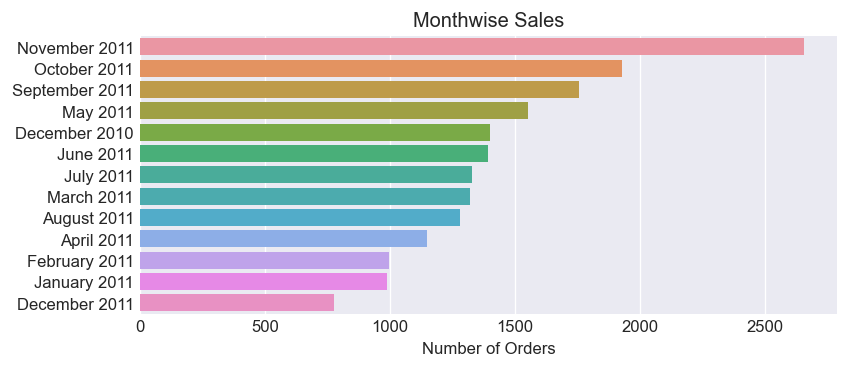

In [73]:
## plotting a bar graph to visualize the sales in different month
plt.subplots(figsize = (7.5, 3), dpi = 120)
ax = sns.barplot(y = busiest_month['InvoiceMonth'],
           x = busiest_month['N_Orders'])
ax.set_ylabel('')
ax.set_xlabel("Number of Orders")
plt.title("Monthwise Sales")
plt.show()

In [74]:
## busiest month revenue
total_revenue_nov = busiest_month['RevenueGenerated'].iloc[0]

print(f"Highest Monthly Revenue: {busiest_month['InvoiceMonth'].iloc[0]} (£{total_revenue_nov})")

print(f"Percentage of Total Revenue by {busiest_month['InvoiceMonth'].iloc[0]}: {np.round(busiest_month['RevenueGenerated'].iloc[0]*100/master_df['InvoicedPrice'].sum(),2)}%")

Highest Monthly Revenue: November 2011 (£1156205.61)
Percentage of Total Revenue by November 2011: 13.01%


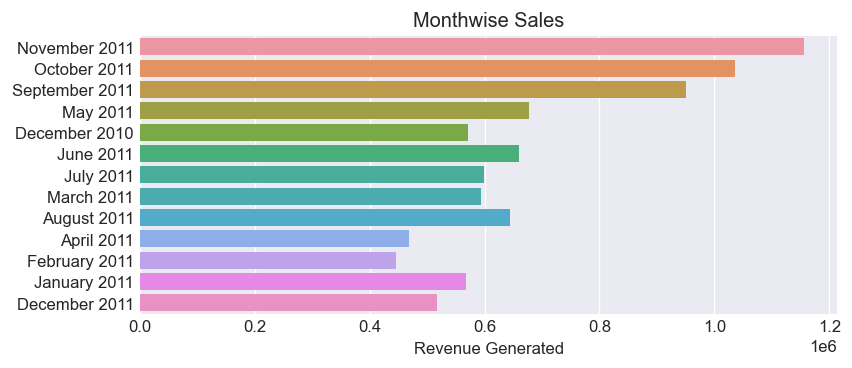

In [75]:
## plotting a bar graph to visualize the revenue generate in different month
plt.subplots(figsize = (7.5, 3), dpi = 120)
ax = sns.barplot(x = busiest_month['RevenueGenerated'],
                 y = busiest_month['InvoiceMonth'])
ax.set_ylabel('')
ax.set_xlabel("Revenue Generated")
plt.title("Monthwise Sales")
plt.show()

#### During the busiest month i.e. **November  2011**, let's see which country contributed the most to sales. <a name = '#busiest-month'></a>

In [76]:
## top 5 countries to contribute to most revenue in November'11
master_df[master_df['InvoiceDate'].dt.to_period('M') == pd.Period('2011-11', freq='M')].groupby('Country').agg({'InvoicedPrice':'sum'}).reset_index().rename({"InvoicedPrice":"Total_Revenue"}, axis=1).sort_values('Total_Revenue', ascending=False).reset_index(drop=True).head(5)

,Country,Total_Revenue
0,United Kingdom,975251.39
1,France,31274.75
2,EIRE,29448.41
3,Germany,27967.68
4,Netherlands,25874.01


- Top 5 countries that drove *HIGHEST MONTHLY REVENUE* in **November 2011**.

In [77]:
## top 5 countries to contribute to most orders in November'11
master_df[master_df['InvoiceDate'].dt.to_period('M') == pd.Period('2011-11', freq='M')].groupby('Country').agg({'InvoiceNo':'nunique'}).reset_index().rename({"InvoiceNo":"N_Orders"}, axis=1).sort_values('N_Orders', ascending=False).reset_index(drop=True).head(5)

,Country,N_Orders
0,United Kingdom,2387
1,Germany,68
2,France,62
3,EIRE,39
4,Netherlands,15


- Top 5 countries with *HIGHEST NUMBER OF MONTHLY ORDERS* in **November 2011**.

In [78]:
## fetching the number of total orders made in November 2011
master_df[master_df['InvoiceDate'].dt.to_period('M') == pd.Period('2011-11', freq='M')].groupby('Country').agg({'InvoiceNo':'nunique'}).reset_index().rename({"InvoiceNo":"N_Orders"}, axis=1).sort_values('N_Orders', ascending=False)['N_Orders'].sum()

2658

In [79]:
## Number of orders received from United Kingdom in Nov'11 -> 2387
## Number of total orders in Nov'11 -> 2698
np.round(2387*100/2658, 2)

89.8

**Observation:**
- **Number of Orders** peaked in **November 2011**.
- **November 2011** was the **BUSIEST MONTH** in the given period.
- Also, **November 2011** generated **HIGHEST MONTHLY REVENUE** for the business in the given period.

#### Why did sales shoot up in November 2011?
- In Nov 2011, almost 90% of the orders were from **United Kingdom (UK)**.
- Since November is the pre-christmas month, one of the plausible reasons could be the pre-festive shopping of the customers.
- Another reason for the sales shooting up in Nov 2011 could be any **SALE** on the website. We'll check if that's the case in the further EDA process.

### 5.5.5. Check for SALE (in Nov'11) <a name='check-sale'></a>

- We'll check if there was any a SALE going on in Nov-2011.

In [80]:
## number of unique `StockCode` and `UnitPrice` combination
master_df[['StockCode', 'UnitPrice']].drop_duplicates()

,StockCode,UnitPrice
0,85123A,2.55
6,85123A,2.95
255,85123A,3.24
767,85123A,2.40
1516,85123A,3.20
...,...,...
392726,90214U,0.29
392727,90214W,0.29
392728,90214Z,0.29
392729,90089,0.19


In [81]:
## number of unique products
master_df.StockCode.nunique()

3665

- We can see that there are different `UnitPrice` values for any particular `StockCode`. This is common phenomenon as the price of products keep fluctuating over time. 

In [82]:
## creating a separate dataframe with mean UnitPrice for products sold in November 2011
nov_unitprice = master_df[(master_df['InvoiceDate'].dt.to_period("M") == pd.Period("2011-11", freq="M"))].groupby("StockCode").agg({'UnitPrice':'mean'}).reset_index().rename({'UnitPrice':'Nov_UnitPrice'}, axis = 1)

In [83]:
## creating  a separate dataframe with mean UnitPrice for products sold in the rest of the operational time
rest_unitprice = master_df[~(master_df['InvoiceDate'].dt.to_period("M") == pd.Period("2011-11", freq="M"))].groupby("StockCode").agg({'UnitPrice':'mean'}).reset_index().rename({'UnitPrice':'Rest_UnitPrice'}, axis = 1)

In [84]:
print(f"Number of Products NOT sold in Nov-2011: {master_df['StockCode'].nunique() - nov_unitprice.StockCode.nunique()}")

Number of Products NOT sold in Nov-2011: 970


In [85]:
print(f"Number of Products ONLY sold in Nov-2011: {len([item for item in nov_unitprice['StockCode'].to_list() if item not in rest_unitprice['StockCode'].to_list()])}")

Number of Products ONLY sold in Nov-2011: 19


- <a name="discuss"></a> We have to join these above DataFrame using **INNER** join because there are 970 such products that are NOT sold in **November'11** and 19 such product that are ONLY sold in **November'11**.

In [86]:
## creating a dataframe to combine the mean UnitPrice of both Nov'11 and the rest of the operation period to compare UnitPrice across products
check_sale = rest_unitprice.merge(nov_unitprice, how='inner', on='StockCode')

In [87]:
## rounding off the values to 2 decimal places
check_sale['Rest_UnitPrice'] = np.round(check_sale['Rest_UnitPrice'], 2)
check_sale['Nov_UnitPrice'] = np.round(check_sale['Nov_UnitPrice'], 2)

In [88]:
## creating a new column to quantify the price difference
check_sale['UnitPrice_diff'] = check_sale['Rest_UnitPrice'] - check_sale['Nov_UnitPrice']

In [89]:
## fetching the head of the newly made dataframe
check_sale.head()

,StockCode,Rest_UnitPrice,Nov_UnitPrice,UnitPrice_diff
0,10080,0.42,0.39,0.03
1,10120,0.21,0.21,0.00
2,10124A,0.42,0.42,0.00
3,10124G,0.42,0.42,0.00
4,10125,0.78,0.85,-0.07


In [90]:
## checking the shape of the latest dataframe
check_sale.shape

(2676, 4)

**Note**: Despite having 3665 unique products sold between Dec'10 - Dec'11, we are only enable to compare the difference in mean `UnitPrice` for 2676 products because as [discussed earlier](#discuss), we have only 2676 products that are sold both in Nov'11 and the rest of the operational period.

#### We have subtracted the mean `UnitPrice` of products for the rest of the year from the same for Nov-2011. If there was an ongoing SALE in Nov-2011, we should expect to see a drop in products' `UnitPrice` as that's what a SALE means.

**Key Points:**
1. A negative value in `UnitPrice_diff` indicates that the mean `UnitPrice` of the particular product was **HIGHER** than the same for the rest of the operational time.
2. On the contrary, a positive value in `UnitPrice_diff` indicates that the mean `UnitPrice` of the particular product was **LOWER** than the same for the rest of the operational time.
3. If we manage to find enough instances of scenario 2, we can conclude that there was an ongoing SALE in November 2011 and one of plausible reasons for sales shooting up in November 2011 could be this.

In [91]:
## checking the descriptive stats for the `UnitPrice_diff` column
check_sale['UnitPrice_diff'].describe()

count    2676.000000
mean       -0.275732
std        14.711350
min      -742.920000
25%        -0.100000
50%        -0.010000
75%         0.000000
max       151.830000
Name: UnitPrice_diff, dtype: float64

In [92]:
## percentge product that were sold at a HIGHER price than the rest of the operational time
print(f"Percentage of total products that are sold at a HIGHER price in Nov'11: {np.round(check_sale[(check_sale['UnitPrice_diff'] <= 0)].shape[0]*100/check_sale.shape[0], 2)}%")

Percentage of total products that are sold at a HIGHER price in Nov'11: 78.44%


In [93]:
## fetching the product that witnessed the highest price spike in Nov'11
check_sale[(check_sale['UnitPrice_diff'] == check_sale['UnitPrice_diff'].min())]

,StockCode,Rest_UnitPrice,Nov_UnitPrice,UnitPrice_diff
2673,DOT,558.42,1301.34,-742.92


**Observation:**
- Almost 78.5% products didn't see a price cut in November 2011.
- Even to our surprise, the mean price of one of the products (`StockCode` == "DOT") shot up by more than 100%.

In [94]:
## Checking the descriptive stats for products that were actually sold at a discounted rate
check_sale[(check_sale['UnitPrice_diff'] > 0)]['UnitPrice_diff'].describe()

count    577.000000
mean       0.730191
std        6.730752
min        0.010000
25%        0.030000
50%        0.090000
75%        0.260000
max      151.830000
Name: UnitPrice_diff, dtype: float64

In [95]:
## checking which product saw the maximum price cut
check_sale[(check_sale['UnitPrice_diff'] == check_sale['UnitPrice_diff'].max())]

,StockCode,Rest_UnitPrice,Nov_UnitPrice,UnitPrice_diff
2674,M,197.56,45.73,151.83


In [96]:
## checking the price statistics for the "M" product
master_df[(master_df['StockCode'] == "M")]['UnitPrice'].describe()

count     285.000000
mean      174.650211
std       584.542997
min         0.000000
25%         0.420000
50%         1.450000
75%        12.750000
max      4161.060000
Name: UnitPrice, dtype: float64

In [97]:
## checking the number of products saw a price cut
print(f"Number of product sold at a discounted price in Nov'11: {check_sale[(check_sale['UnitPrice_diff'] > 0)].shape[0]}")

Number of product sold at a discounted price in Nov'11: 577


In [98]:
## checking the percentage of products seeing a price cut in November 2011 
print(f"Percentage of products sold at a discounted price in Nov'11: {np.round(check_sale[(check_sale['UnitPrice_diff'] > 0)].shape[0]*100/check_sale.shape[0],2)}%")

Percentage of products sold at a discounted price in Nov'11: 21.56%


**Observations:**
- Almost 79% of all the products sold in Nov'11 were sold at a **HIGHER** price than the rest of the operations time.
- Only 21.5% of all the products sold in Nov'11 saw a price-cut.
- 75% of the products that were sold at a **LOWER** price saw a price cut of JUST **0.26** in Nov'11.
- The maximum price-cut was of 150.88 for a product that goes by the `StockCode` "M". This is also not conclusive enough to consider it to be a SALE price. Because as we saw here, in 75% occasions, the product "M" was sold at less than 13.85.

#### Conclusion: There was NO ongoing SALE in November 2011. Hence, for more reasons for the sales shooting up in November 2011, we have to consult a domain expert.

### 5.5.6. Orders by `Days`<a name='orders-days'></a>

In [99]:
## fetching weekdays on which the business received at least one order
master_df['InvoiceDate'].dt.day_name().unique()

array(['Wednesday', 'Thursday', 'Friday', 'Sunday', 'Monday', 'Tuesday'],
      dtype=object)

- Looks like the business never received an order on **Saturday**.

### Q4. Which is the busiest day of the week?

In [100]:
## creating a DataFrame to store daywise sales and total revenue
busiest_day = master_df.groupby(master_df['InvoiceDate'].dt.day_name()).agg({'InvoiceNo':'nunique', 'InvoicedPrice':'sum'}).rename({'InvoiceNo':'N_Orders', "InvoicedPrice":'Total_Revenue'}, axis=1)

In [101]:
## sorting the dataframe by `Total_Revenue` in descending order
busiest_day.sort_values(['Total_Revenue'], ascending = False)

,N_Orders,Total_Revenue
InvoiceDate,,
Thursday,4033,1973015.730
Tuesday,3185,1697733.801
Wednesday,3455,1584283.830
Friday,2831,1483080.811
Monday,2863,1363604.401
Sunday,2169,785490.321


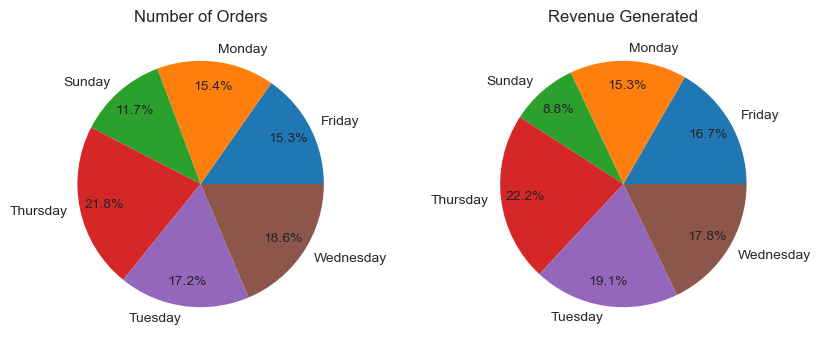

In [102]:
## creating the pie chart
fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (10,4), dpi = 100)
ax[0].pie(busiest_day['N_Orders'],
                                 labels = busiest_day.index,
                                 autopct = lambda pct: f'{pct:.1f}%',
                                 pctdistance = 0.8)
ax[0].set_title("Number of Orders")

ax[1].pie(busiest_day['Total_Revenue'],
                                 labels = busiest_day.index,
                                 autopct = lambda pct: f'{pct:.1f}%',
                                 pctdistance = 0.8)
ax[1].set_title("Revenue Generated")

# Show the pie chart
plt.show()

**Observations:**
- The data is **ALMOST** evenly distributed across all the different days of the week.
- Although **Thursday** is the BUSIEST day of the week both in terms of most sales and most revenue generation, it doesn't have a significantly large impact on the overall business.

### 5.5.7. Rush Hour <a name='rush-hour'></a>

In [103]:
## creating a dataframe that shows number of orders and total revenue generated by hours
rush_hour = master_df.groupby(master_df['InvoiceDate'].dt.hour).agg({'InvoiceNo':'nunique', 'InvoicedPrice':'sum'}).reset_index().rename({"InvoiceDate":"InvoiceHour", 'InvoiceNo':'N_Orders', "InvoicedPrice":'Total_Revenue'}, axis=1)

In [104]:
## chaning dtype of InvoiceHour to object to avoid confusion during visualization
rush_hour['InvoiceHour'] = rush_hour['InvoiceHour'].astype('object')

In [105]:
## fetching the head of the dataframe
rush_hour.head()

,InvoiceHour,N_Orders,Total_Revenue
0,6,1,4.250
1,7,29,31059.210
2,8,555,281997.790
3,9,1394,842392.341
4,10,2226,1259267.591


In [106]:
## checking the summary of the latest dataframe
rush_hour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   InvoiceHour    15 non-null     object 
 1   N_Orders       15 non-null     int64  
 2   Total_Revenue  15 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 492.0+ bytes


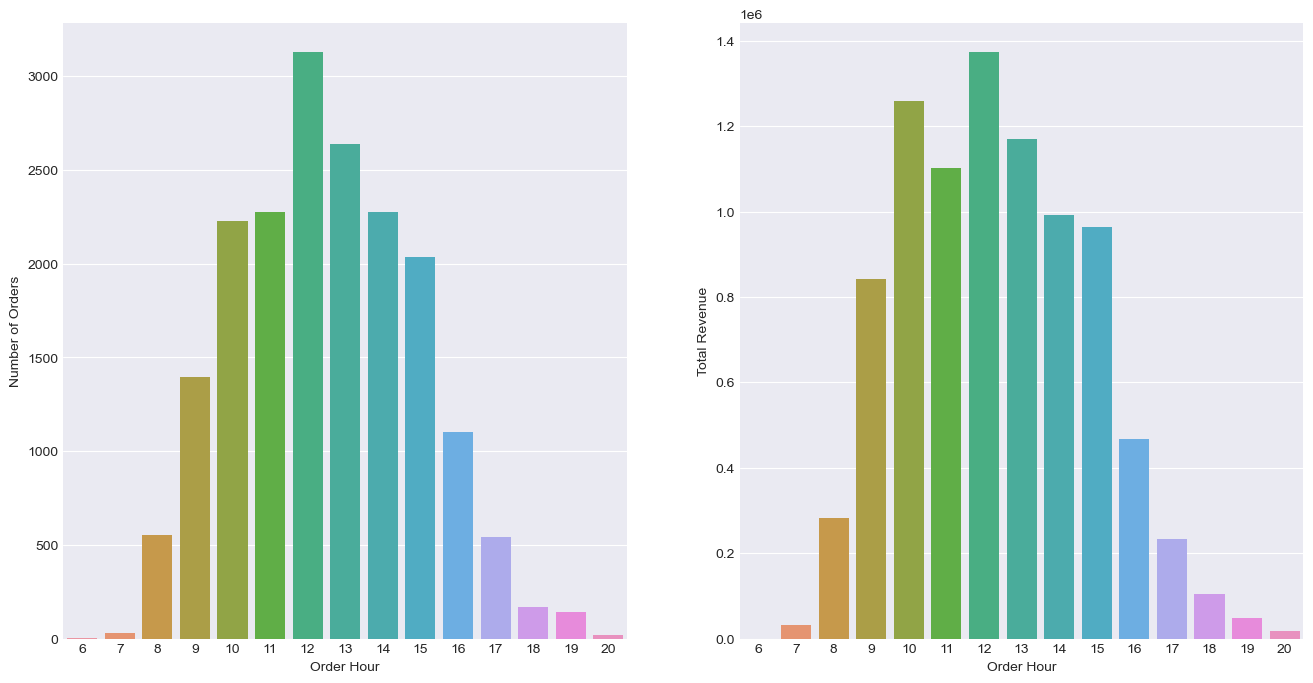

In [107]:
## creating two barplots: one for Number of Orders received and another for Total Revenue Generated
fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (16,8))
g = sns.barplot(x = rush_hour['InvoiceHour'],
                y = rush_hour['N_Orders'],
                ax = axs[0])
g.set_ylabel("Number of Orders")
g.set_xlabel("Order Hour")

h = sns.barplot(x = rush_hour['InvoiceHour'],
                y = rush_hour['Total_Revenue'],
                ax = axs[1])
h.set_ylabel("Total Revenue")
h.set_xlabel("Order Hour")

plt.show()

**Observations:**
- Apparently, the **RUSH HOUR** is from **12:00 PM to 02:00 PM** for the business.
- With this information, company's website can be better optimized for that specific time-period.
- Also, we can make sure that the company avoids routine maintenance during the **Rush Hour**.
- That way customer-bounce-rate can be minimized.

### 5.6. Analyzing `Country` <a name='country-analysis'></a>

In [108]:
## fetching the number of unique countries, the business ships its product to
master_df['Country'].nunique()

37

In [109]:
## creating a dataframe containing country wise sales and sales revenue for further analysis
country_wise = master_df.groupby('Country').agg({"InvoiceNo":"nunique", "InvoicedPrice":'sum'}).sort_values(by='InvoicedPrice', ascending = False).reset_index().rename({"InvoiceNo":"N_Orders", "InvoicedPrice":'Total_Revenue'}, axis = 1)

In [110]:
## creating a column to show the order percentage
country_wise['%_N_Orders'] = np.round(country_wise['N_Orders']*100/country_wise['N_Orders'].sum(),2)

In [111]:
## creating a column to show the revenue percentage
country_wise['%_Total_Revenue'] = np.round(country_wise['Total_Revenue']*100/country_wise['Total_Revenue'].sum(),2)

In [112]:
## fetching the head of the Country dataframe
country_wise.head()

,Country,N_Orders,Total_Revenue,%_N_Orders,%_Total_Revenue
0,United Kingdom,16649,7285024.644,89.82,81.97
1,Netherlands,95,285446.340,0.51,3.21
2,EIRE,260,265262.460,1.40,2.98
3,Germany,457,228678.400,2.47,2.57
4,France,389,208934.310,2.10,2.35


### 5.6.1. Top 5 Countries <a name='top-five'></a>

In [113]:
## fetching top 5 countries contributing to most revenue
country_wise.sort_values(['Total_Revenue'], ascending = False).head()

,Country,N_Orders,Total_Revenue,%_N_Orders,%_Total_Revenue
0,United Kingdom,16649,7285024.644,89.82,81.97
1,Netherlands,95,285446.340,0.51,3.21
2,EIRE,260,265262.460,1.40,2.98
3,Germany,457,228678.400,2.47,2.57
4,France,389,208934.310,2.10,2.35


In [114]:
## fetching top 5 countries contributing to most orders
country_wise.sort_values(['N_Orders'], ascending = False).head()

,Country,N_Orders,Total_Revenue,%_N_Orders,%_Total_Revenue
0,United Kingdom,16649,7285024.644,89.82,81.97
3,Germany,457,228678.400,2.47,2.57
4,France,389,208934.310,2.10,2.35
2,EIRE,260,265262.460,1.40,2.98
8,Belgium,98,41196.340,0.53,0.46


**Observations:**
- The Online Retail Stores serves in 37 countries.
- The business is mostly present in **United Kingdom (UK)**.
- **United Kingdom (UK)** drove almost 90% of sales and 82% of sales revenue.
- Most selling product in Top 5 Countries are discussed [here](#country-wise).

### 5.7. Analyzing `CustomerID` <a name='customer-analysis'></a>

In [115]:
## total number of unique customers aquired by the business
master_df['CustomerID'].nunique()

4339

### 5.7.1. Top 5 Most Valuable Customers <a name='top-five-cust'></a>

In [116]:
## fetching the top 5 customers by total revenue generated by the business from them 
master_df.groupby('CustomerID').agg({'InvoicedPrice':'sum'}).sort_values('InvoicedPrice', ascending = False).reset_index().rename({"InvoicedPrice":"Total_Revenue"}, axis = 1).head()

,CustomerID,Total_Revenue
0,14646,280206.02
1,18102,259657.30
2,17450,194390.79
3,16446,168472.50
4,14911,143711.17


### 5.7.2. Average Spent <a name='avg-spent'></a>

In [117]:
## fetching the descriptive stats to understand customers' spending
master_df.groupby("InvoiceNo").agg({'InvoicedPrice':'sum'}).reset_index().rename({'InvoicedPrice':'TotalSpent'}, axis=1)['TotalSpent'].describe()

count     18536.000000
mean        479.456673
std        1677.916285
min           0.000000
25%         157.200000
50%         302.565000
75%         469.467500
max      168469.600000
Name: TotalSpent, dtype: float64

In [118]:
## checking the skewness of the distribution of total spent by customers
master_df.groupby("InvoiceNo").agg({'InvoicedPrice':'sum'}).reset_index().rename({'InvoicedPrice':'TotalSpent'}, axis=1)['TotalSpent'].skew()

62.15879078130721

**Observations:**
- 75% customers spent less than £470.
- Highest Customer Spent: £168,469
- Since the distribution is heavily right-skewed, it's safe to say most customers on the platforms spend less than £302.

## 6.0. Cohort Analysis <a name='cohort'></a>


Cohort analysis is a strategic analytical technique used by businesses, including online retail stores, to gain deeper insights into customer behavior, retention, and overall business performance. It involves grouping customers into cohorts based on shared characteristics or actions and analyzing their behavior over time.

Key aspects of cohort analysis include:

- **Cohort Formation:** Customers are grouped into cohorts based on a common characteristic or action, such as the month they made their first purchase, the marketing channel they came through, or their demographic profile.

- **Behavioral Analysis:** Cohorts are then analyzed to understand how different groups of customers behave over time. This analysis can reveal trends in retention rates, purchase frequency, average order value, and customer lifetime value (CLV).

- **Segmentation and Personalization:** Insights from cohort analysis enable businesses to segment customers more effectively and personalize marketing, product offerings, and communication strategies based on specific cohort characteristics and behavior patterns.

In [119]:
## fetching total number of unique customers
master_df['CustomerID'].nunique()

4339

**Observations:**
- The business managed to acquire 4338 unique customers over a span of 13 months.
- Now, we have to consider customer retention on a monthly basis.
- Hence, we'll create a Retention Matrix for our Cohort Analysis on Customer Retention.

### 6.1. Retention Matrix <a name='retention'></a>

In [120]:
## creating a new column by extracting only the invoice month from the InvoiceDate 
master_df['InvoiceMonth'] = master_df['InvoiceDate'].dt.to_period("M")

In [121]:
## creating a new column for indentifying the month a customer was first acquired in
master_df['CohortMonth'] = master_df.groupby('CustomerID')['InvoiceMonth'].transform('min')

In [122]:
## creating an index based on the months a customer was active on the platform
master_df['CohortIndex'] = (master_df['InvoiceMonth'] - master_df['CohortMonth']).apply(attrgetter('n'))

## fetching the head
master_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoicedPrice,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.3,2010-12,2010-12,0
1,536373,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 09:02:00,2.55,17850,United Kingdom,15.3,2010-12,2010-12,0
2,536375,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 09:32:00,2.55,17850,United Kingdom,15.3,2010-12,2010-12,0
3,536390,85123A,WHITE HANGING HEART T-LIGHT HOLDER,64,2010-12-01 10:19:00,2.55,17511,United Kingdom,163.2,2010-12,2010-12,0
4,536394,85123A,WHITE HANGING HEART T-LIGHT HOLDER,32,2010-12-01 10:39:00,2.55,13408,United Kingdom,81.6,2010-12,2010-12,0


In [123]:
#creating a new DataFrame segregating customers based on the month they were acquired and the number of months they were active
cohort_data = master_df.groupby(['CohortMonth','CohortIndex'])['CustomerID'].nunique().reset_index().rename({'CustomerID':'N_Customers'}, axis = 1)

## fetching the head
cohort_data.head()

,CohortMonth,CohortIndex,N_Customers
0,2010-12,0,885
1,2010-12,1,324
2,2010-12,2,286
3,2010-12,3,340
4,2010-12,4,321


In [124]:
## pivoting the data to prepare a retention matrix having CohortIndex as columns
cohort_table = cohort_data.pivot_table(columns = "CohortIndex", index="CohortMonth", values = "N_Customers")

## fetching the newly created table
cohort_table

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [125]:
## setting the cohort size
cohort_size = cohort_table.iloc[:, 0]

In [126]:
## creating the retention matrix
retention_matrix = cohort_table.divide(cohort_size, axis=0)

## showing the matrix
retention_matrix

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12,1.0,0.366102,0.323164,0.384181,0.362712,0.397740,0.362712,0.349153,0.353672,0.395480,0.374011,0.502825,0.265537
2011-01,1.0,0.220624,0.266187,0.230216,0.321343,0.287770,0.247002,0.242206,0.299760,0.326139,0.364508,0.117506,NaN
2011-02,1.0,0.186842,0.186842,0.284211,0.271053,0.247368,0.252632,0.278947,0.247368,0.305263,0.068421,NaN,NaN
2011-03,1.0,0.150442,0.252212,0.199115,0.223451,0.168142,0.267699,0.230088,0.278761,0.086283,NaN,NaN,NaN
2011-04,1.0,0.213333,0.203333,0.210000,0.196667,0.226667,0.216667,0.260000,0.073333,NaN,NaN,NaN,NaN
2011-05,1.0,0.190141,0.172535,0.172535,0.207746,0.232394,0.264085,0.095070,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.173554,0.157025,0.264463,0.231405,0.334711,0.095041,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.180851,0.207447,0.223404,0.271277,0.111702,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.207101,0.248521,0.242604,0.124260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [127]:
## setting the cohort_size to readable format
cohort_size.index = cohort_size.index.strftime('%B %Y')

### 6.2. Cohort Analysis Heatmap <a name="heatmap"></a>

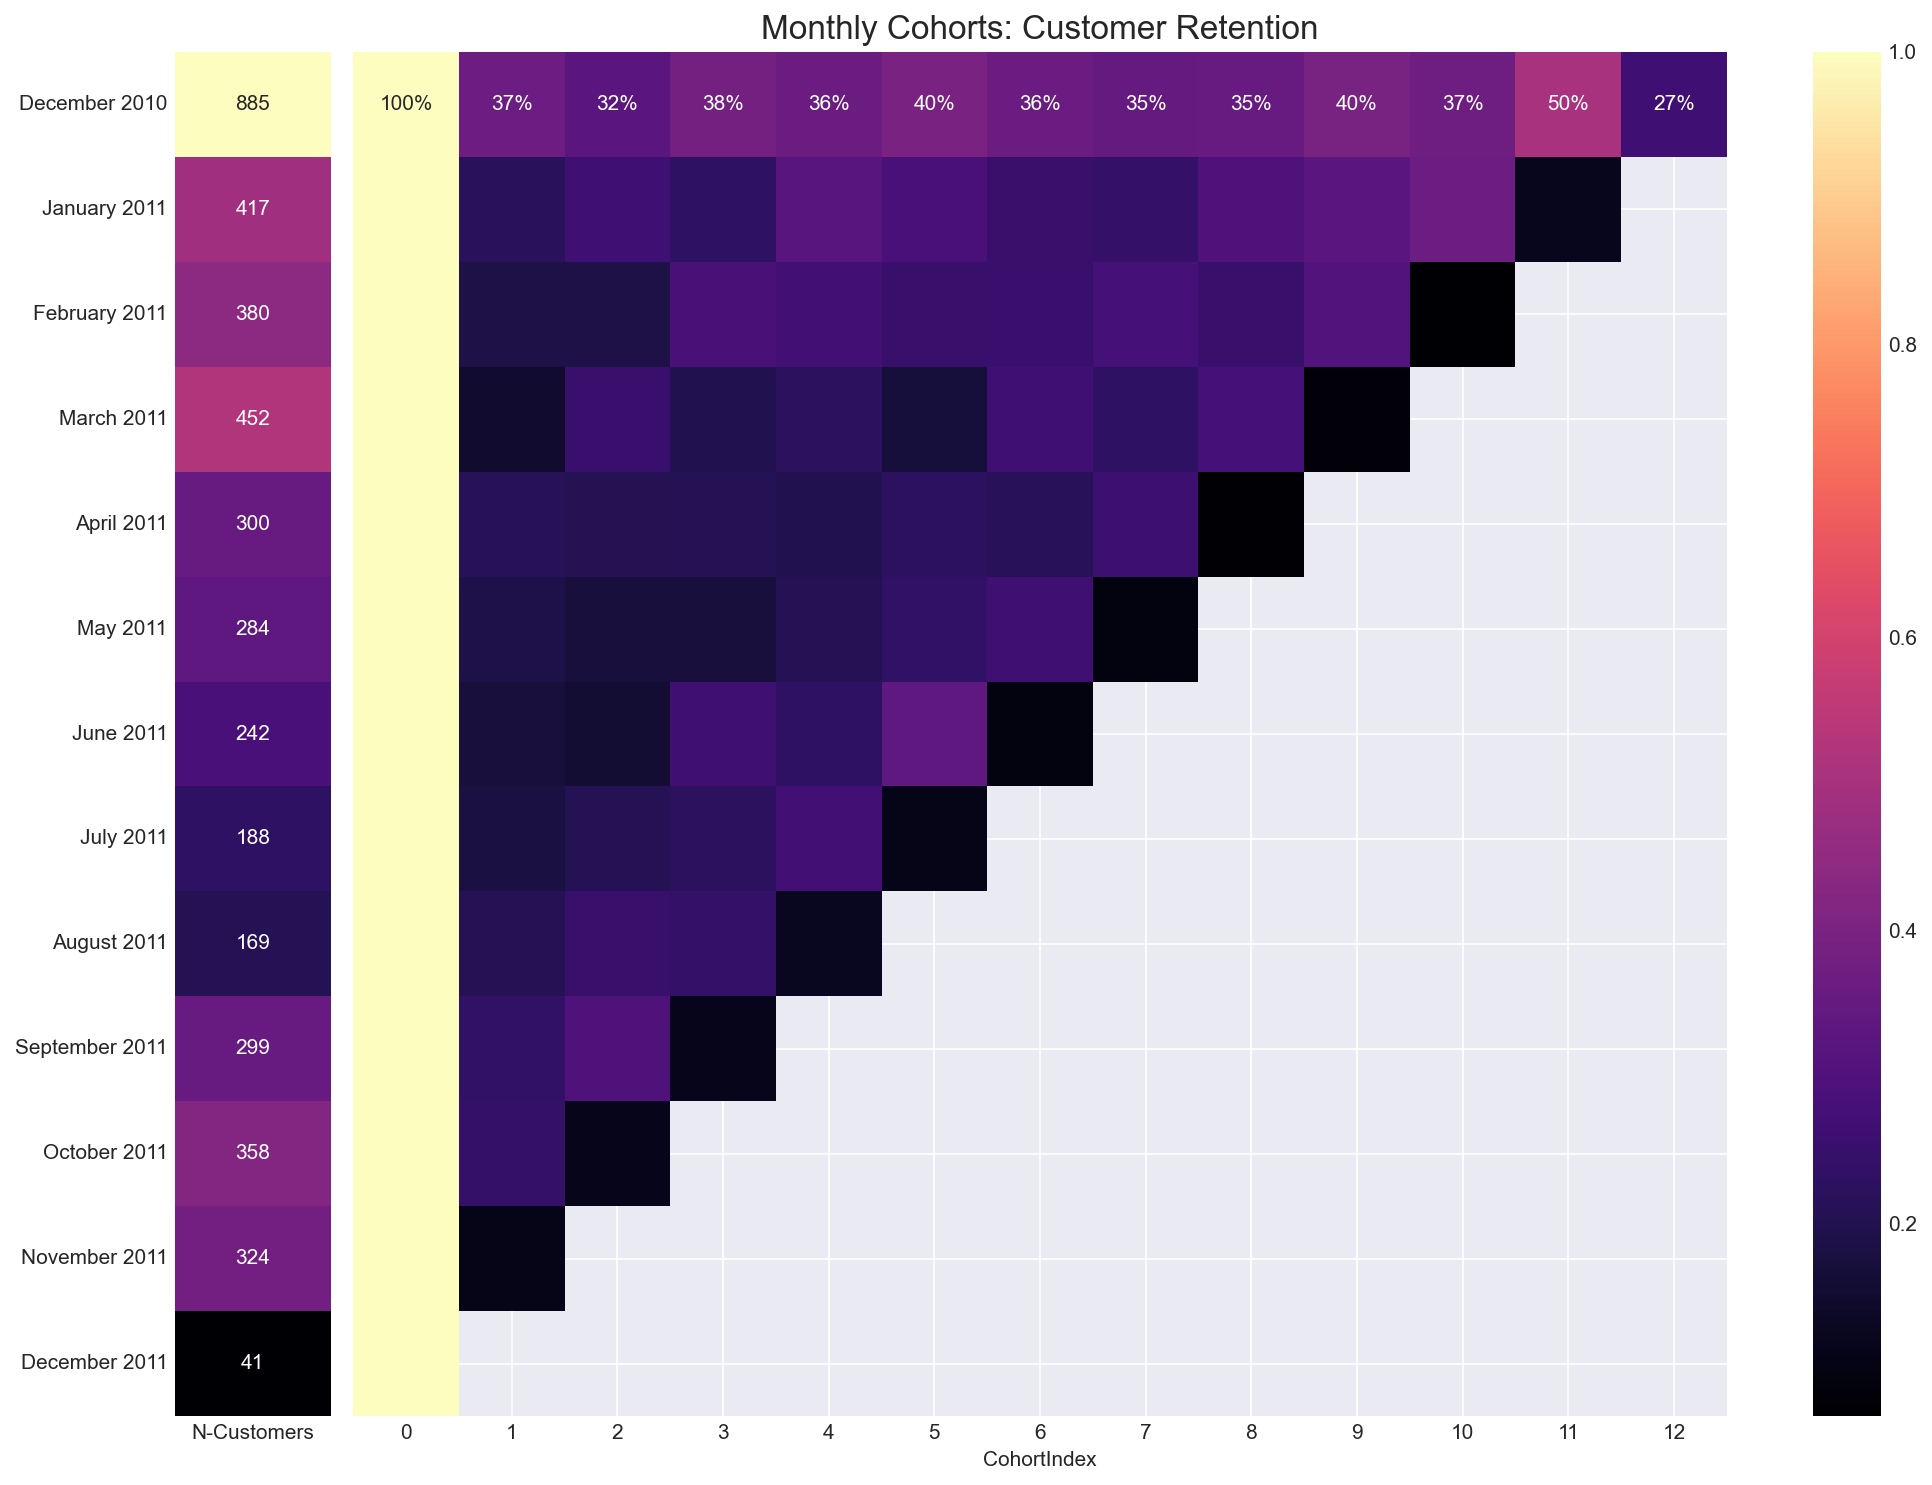

In [128]:
## plotting the cohort heatmap
fig, ax = plt.subplots(1, 2, figsize=(14, 10), sharey=True, gridspec_kw={'width_ratios': [1, 11]}, dpi = 150)

# retention matrix
sns.heatmap(retention_matrix, 
            mask = retention_matrix.isnull(), 
            annot = True, 
            fmt = '.0%', 
            cmap = sns.color_palette("magma", as_cmap=True), 
            ax = ax[1])
ax[1].set_title('Monthly Cohorts: Customer Retention', fontsize=16)
ax[1].set(ylabel = '')

# cohort size
cohort_size_df = pd.DataFrame(cohort_size).rename(columns = {0: 'N-Customers'})
sns.heatmap(cohort_size_df, 
            annot = True, 
            cbar = False, 
            fmt = 'g',
            ax = ax[0],
            cmap = sns.color_palette("magma", as_cmap=True))
ax[0].set(ylabel = '')

fig.tight_layout()

#### Benefits of Cohort Analysis:
Beyond marketing, cohort analysis offers several strategic benefits for online retail businesses:

- **Retention Strategies:** Identifying cohorts with high retention rates allows businesses to develop targeted retention strategies, such as loyalty programs, personalized offers, and re-engagement campaigns, to maximize customer lifetime value and reduce churn.

- **Product Insights:** Analyzing cohort behavior can provide valuable insights into product performance, feature adoption, and customer preferences, guiding product development, pricing strategies, and inventory management decisions.

- **Operational Optimization:** Cohort analysis can inform operational decisions, such as resource allocation, customer support prioritization, and supply chain management, to improve efficiency and customer satisfaction.

By leveraging cohort analysis, online retail stores can make data-driven decisions, enhance customer experiences, drive long-term loyalty, and optimize business processes for sustainable growth nd competitiveness.

## 7.0. RFM Analysis


RFM analysis is a strategic approach used by businesses, including online retail stores, to gain deep insights into customer behavior and optimize various aspects of operations. The acronym RFM stands for Recency, Frequency, and Monetary Value, which are fundamental metrics used to assess customer engagement, loyalty, and value to the business.

- **Recency (R):** This factor evaluates how recently a customer has interacted or transacted with the business. It helps identify active and engaged customers versus those who may need re-engagement strategies.

- **Frequency (F):** Frequency measures how often a customer engages with the business within a specific timeframe. It indicates customer loyalty, repeat purchases, and the potential for ongoing revenue generation.

- **Monetary Value (M):** Monetary value reflects the total amount of money a customer has spent on products or services. It highlights high-value customers who contribute significantly to revenue and profitretail landscape.


In [129]:
## creating a separate dataframe aggregating customer information like last date of order, total orders, and total sum spent
customers = master_df.groupby("CustomerID").agg({'InvoiceDate':'max', 'InvoiceNo': 'count', 'InvoicedPrice': 'sum'}).reset_index().rename(columns = {'InvoiceDate': 'LastOrderOn', 'InvoiceNo':'N_Orders', 'InvoicedPrice': 'TotalSpent'})

In [130]:
## Supposing the analysis is being done on the day after the last order was placed
analysis_date = customers['LastOrderOn'].max() + pd.Timedelta(days=1)

In [131]:
## creating a new column that quantifies the number of days since the user placed the last order
customers['LastOrderSince'] = (analysis_date - customers['LastOrderOn']).dt.days

In [132]:
## fetching the descriptive stats for the numeric columns of the customer dataframe
customers.describe(exclude = ['datetime64', 'object']).transpose()

,count,mean,std,min,25%,50%,75%,max
N_Orders,4339.0,90.512100,225.515328,1.0,17.000,41.00,98.000,7676.00
TotalSpent,4339.0,2048.215924,8984.248352,0.0,306.455,668.56,1660.315,280206.02
LastOrderSince,4339.0,92.518322,100.009747,1.0,18.000,51.00,142.000,374.00


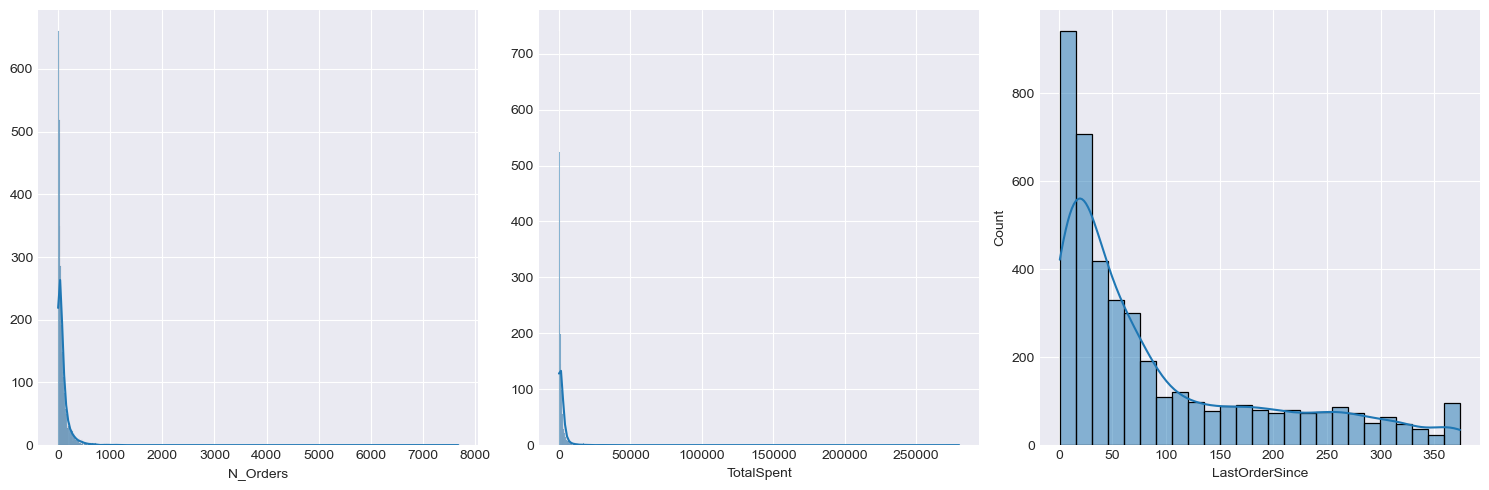

In [133]:
## creating three histograms to understand the underlying distributions
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

## for N_Orders
sns.histplot(data = customers, x = 'N_Orders', kde = True, ax = axs[0])
axs[0].set_ylabel('')

## for TotalSpent
sns.histplot(data = customers, x = 'TotalSpent', kde = True, ax = axs[1])
axs[1].set_ylabel('')

## for LastOrderSince
sns.histplot(data = customers, x = 'LastOrderSince', kde = True, ax = axs[2])
axs[0].set_ylabel('')

## adjusting layout
plt.tight_layout()
plt.show()

In [134]:
for col in customers.drop(['CustomerID', 'LastOrderOn'], axis = 1).columns:
    print(f"Skewness for {col}: {np.round(customers[col].skew(),2)}")

Skewness for N_Orders: 18.04
Skewness for TotalSpent: 19.34
Skewness for LastOrderSince: 1.25


**Note:** All three columns are right-skewed.

**Plan of Action:**
1. We'll bucket each column based on the quantile value to assign a score for Recency(R), Frequency(F) and Monetary(M).
2. We'll aggregate these scores for Customer Segmentation.

In [135]:
## for calculation the R, F and M off the columns
def calculateScore(value, col, reverse = False):
    if value <= customers[col].quantile(0.1):
        return 1 if not reverse else 10
    elif value <= customers[col].quantile(0.2):
        return 2 if not reverse else 9
    elif value <= customers[col].quantile(0.3):
        return 3 if not reverse else 8
    elif value <= customers[col].quantile(0.4):
        return 4 if not reverse else 7
    elif value <= customers[col].quantile(0.5):
        return 5 if not reverse else 6
    elif value <= customers[col].quantile(0.6):
        return 6 if not reverse else 5
    elif value <= customers[col].quantile(0.7):
        return 7 if not reverse else 4
    elif value <= customers[col].quantile(0.8):
        return 8 if not reverse else 3
    elif value <= customers[col].quantile(0.9):
        return 9 if not reverse else 2
    else:
        return 10 if not reverse else 1

In [136]:
## calculating R
customers['R'] = customers['LastOrderSince'].apply(calculateScore, col = 'LastOrderSince', reverse = True)

In [137]:
## calculating F
customers['F'] = customers['N_Orders'].apply(calculateScore, col = 'N_Orders', reverse = False)

In [138]:
## calculating M
customers['M'] = customers['TotalSpent'].apply(calculateScore, col = 'TotalSpent', reverse = False)

In [139]:
## summing these three to get RFM score
customers['RFM_Score'] = customers['R'] + customers['F'] + customers['M']

In [140]:
## fetching the descriptive stats for the RFM_score
customers['RFM_Score'].describe()

count    4339.000000
mean       16.481447
std         7.340517
min         3.000000
25%        10.000000
50%        16.000000
75%        23.000000
max        30.000000
Name: RFM_Score, dtype: float64

In [141]:
## creating bins based on percentile values
bins = [0, customers['RFM_Score'].quantile(1/3), customers['RFM_Score'].quantile(2/3), customers['RFM_Score'].max()]

## defining labels for the tiers
labels = ['Tier-III', 'Tier-II', 'Tier-I']

## adding a new column 'RFM_Tier' with the tier labels based on binning
customers['RFM_Tier'] = pd.cut(customers['RFM_Score'], bins=bins, labels=labels, include_lowest=True)

In [142]:
## aggregating the data by RFM_Tier
np.round(customers.groupby('RFM_Tier').agg({'CustomerID': 'count', 
                                            'LastOrderSince': 'mean', 
                                            'TotalSpent':'mean', 
                                            'N_Orders': 'mean',}).rename({'CustomerID': '#Customers', 
                                                                          'LastOrderSince': 'AvgInActiveDays', 
                                                                          'N_Orders': '#AvgOrders', 
                                                                          'TotalSpent':'AvgSpent', }), 2).sort_index()

,CustomerID,LastOrderSince,TotalSpent,N_Orders
RFM_Tier,,,,
Tier-I,1424,21.78,4954.37,210.35
Tier-II,1436,71.52,922.88,48.74
Tier-III,1479,181.01,342.76,15.69


#### Benefits of RFM Analysis:
By combining these factors(R, F and M), businesses can create nuanced customer segments and tailor strategies beyond marketing, such as:

- **Operational Efficiency:** Identifying high-frequency customers can inform inventory management, resource allocation, and service prioritization to enhance operational efficiency and customer satisfaction.

- **Customer Experience:** Understanding the buying behavior of different segments enables personalized experiences, targeted promotions, and improved customer support, enhancing overall satisfaction and loyalty.

- **Product Development:** Analyzing purchase patterns and preferences can guide product development, pricing strategies, and cross-selling initiatives to meet evolving customer needs effectively.

RFM analysis, therefore, serves as a powerful tool for data-driven decision-making across various business functions, driving growth, retention, and competitiveness in the dynamic online retail landscape.


## 8.0. Customer Segmentation - Clustering

In [143]:
## preparing input for dataframe my model
X = customers.drop(['CustomerID','LastOrderOn', 'R', 'F', 'M', 'RFM_Score', 'RFM_Tier'], axis=1)

In [144]:
## scaling X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [145]:
## creating a list to score ineria scores
wcss = []

## creating a list to score silhouette scores
sil_scores = []

for k in range(3, 11, 1):
    model = KMeans(n_clusters=k, random_state=101)
    pred = model.fit_predict(X_scaled)
    wcss.append(model.inertia_)
    sil_scores.append(silhouette_score(X_scaled, pred))

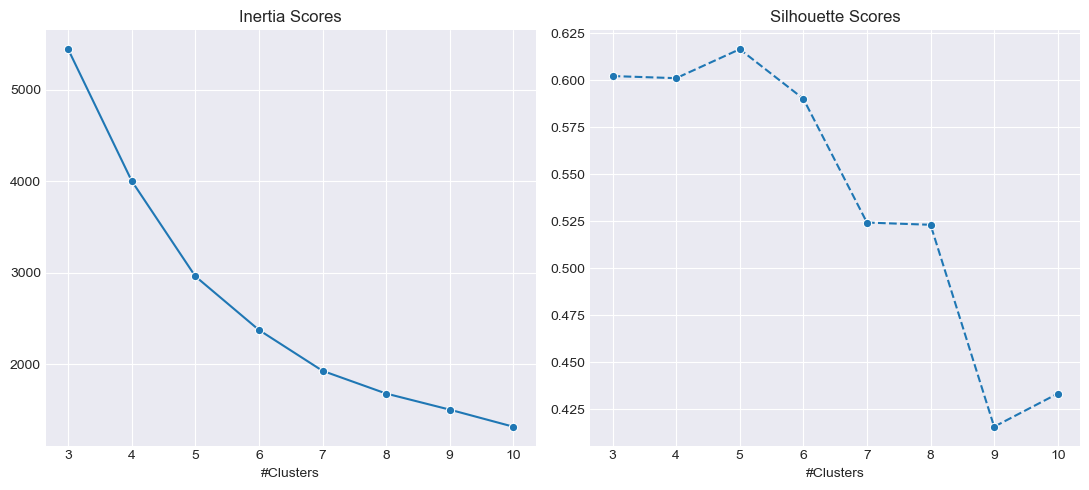

In [146]:
## creating two line plots: one for inertia and the other for silhouette score
fig, axs = plt.subplots(1, 2, figsize = (11, 5))

## for inertia
sns.lineplot(x = list(range(3, 11, 1)), y = wcss, marker = "o", ax = axs[0])
axs[0].set_title('Inertia Scores')
axs[0].set_xlabel('#Clusters')
axs[0].set_xticks(list(range(3, 11, 1)))
axs[0].set_xticklabels(list(range(3, 11, 1)))

## for silhouette score
sns.lineplot(x = list(range(3, 11, 1)), y = sil_scores, marker = "o", ax = axs[1], linestyle = "--");
axs[1].set_title('Silhouette Scores')
axs[1].set_xlabel('#Clusters')
axs[1].set_xticks(list(range(3, 11, 1)))
axs[1].set_xticklabels(list(range(3, 11, 1)))

## adjusting layout
plt.tight_layout()
plt.show()

* From these line plots, we can conclude that **k = 5** is the most appropriate value. Therefore, we'll build the final model for 5 clusters.

In [147]:
## creating the final model for k = 5
final_model = KMeans(n_clusters=5, random_state = 101)

In [148]:
## fetching the predictions
clusters = final_model.fit_predict(X_scaled)

In [149]:
## creating a new column for assigning clusters
customers['Cluster'] = clusters

In [150]:
## fetching the head of the dataframe
customers.head()

,CustomerID,LastOrderOn,N_Orders,TotalSpent,LastOrderSince,R,F,M,RFM_Score,RFM_Tier,Cluster
0,12346,2011-01-18 10:01:00,1,77183.60,326,1,1,10,12,Tier-III,4
1,12347,2011-12-07 15:52:00,182,4310.00,2,10,9,10,29,Tier-I,1
2,12348,2011-09-25 13:13:00,31,1797.24,75,4,5,8,17,Tier-II,1
3,12349,2011-11-21 09:51:00,73,1757.55,19,8,7,8,23,Tier-I,1
4,12350,2011-02-02 16:01:00,17,334.40,310,1,3,3,7,Tier-III,0


In [151]:
## fetching all unique clusters
customers['Cluster'].unique()

array([4, 1, 0, 3, 2])

In [152]:
## aggregating the data by clusters
clusterDF = customers[['Cluster', 'CustomerID', 'N_Orders', 'TotalSpent', 'LastOrderSince', 'RFM_Score']]

In [153]:
## aggregating by clusters
np.round(clusterDF.groupby('Cluster').agg({'CustomerID':'count',
                                  'N_Orders':'mean',
                                  'TotalSpent': 'mean',
                                  'LastOrderSince': 'mean',
                                  'RFM_Score': 'mean'}).sort_values('TotalSpent', ascending = False),2).rename({'CustomerID':'#Customers',
                                                                                            'N_Orders': 'AvgOrders',
                                                                                             'TotalSpent':'AvgSpent',
                                                                                            'LastOrderSince': 'AvgInactiveDays',
                                                                                            'RFM_Score': 'Avg_RFM_Score'}, axis=1)

,#Customers,AvgOrders,AvgSpent,AvgInactiveDays,Avg_RFM_Score
Cluster,,,,,
3,6,826.83,190808.54,7.67,27.67
2,4,5718.00,70612.25,2.00,30.00
4,249,474.10,11751.64,16.25,28.19
1,3025,72.04,1328.30,44.34,18.19
0,1055,27.41,488.76,249.48,8.70


**Observations:**
- Customers in clusters `2` and `3` are significant revenue contributors, comprising 30% of the total revenue.
- Cluster `1`, with nearly 70% of all customers, maintains an average RMF Score slightly above 18. Given the ongoing challenge of customer churn, proactive measures targeting these customers could yield increased order volumes.

## 10.0. Conclusion <a name='summary'></a>

### 10.1. Summary

- **Data Overview**: 541,909 entries, 8 columns.
- **Data Cleaning**: 25% NULL values, 1.28% duplicates removed.
- **Product Analysis**: 3,665 unique items, top seller: PAPER CRAFT, LITTLE BIRDIE.
- **Sales & Revenue**: £8.9M revenue, 18,532 orders, peak in November 2011.
- **Time-based Patterns**: Thursdays (22% of orders & revenue), Rush Hour: 12:00PM - 02:00PM.
- **Geographical Insights**: UK dominates orders & revenue (90%), 37 countries served.
- **Customer Analysis**: 4,338 customers, poor retention. Segmented into 5 clusters by KMeans Clustering.

### 10.2 Recommendations

- **Data Management & Cleaning**: Regularly clean and validate data.
- **Sales Optimization**: Target promotions and analyze high-spenders.
- **Customer Engagement & Retention**: Start a loyalty program and personalize marketing.
- **Time-based Marketing**: Utilize rush hours and optimize Thursdays.
- **Market Expansion & Seasonal Planning**: Explore new markets, customize strategies, and prepare for peak seasons.
- **Customer Retention & Feedback**: Focus on keeping customers during peak periods and gather feedback.
- **Employee Training**: Train staff for peak service.

## Thanks for making it this far. Cheers🥂.